1. 데이터세트 준비
R데이터세트
- item:'Gestation'
- Package: 'mosaicData'
- 목적: 산모의 흡연과 아기의 건강 사이에 연관성이 있는지에 대한 연구를 위한 데이터
- 변수
    - id, pluarlity, outcome, data, gestation, wt, parity, sex, race 등

In [15]:
import pandas as pd
import statsmodels.api as sm

child_smoke=sm.datasets.get_rdataset('Gestation','mosaicData')
child_smoke.data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1236 entries, 0 to 1235
Data columns (total 23 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   id         1236 non-null   int64  
 1   plurality  1236 non-null   object 
 2   outcome    1236 non-null   object 
 3   date       1236 non-null   object 
 4   gestation  1223 non-null   float64
 5   sex        1236 non-null   object 
 6   wt         1236 non-null   int64  
 7   parity     1236 non-null   int64  
 8   race       1223 non-null   object 
 9   age        1234 non-null   float64
 10  ed         1235 non-null   object 
 11  ht         1214 non-null   float64
 12  wt.1       1200 non-null   float64
 13  drace      1190 non-null   object 
 14  dage       1229 non-null   float64
 15  ded        1223 non-null   object 
 16  dht        744 non-null    float64
 17  dwt        737 non-null    float64
 18  marital    1234 non-null   object 
 19  inc        1112 non-null   object 
 20  smoke   

In [16]:
child_smoke.data.head()

,id,plurality,outcome,date,gestation,sex,wt,parity,race,age,ed,ht,wt.1,drace,dage,ded,dht,dwt,marital,inc,smoke,time,number
0,15,single fetus,live birth,1964-11-11,284.0,male,120,1,asian,27.0,College graduate,62.0,100.0,asian,31.0,College graduate,65.0,110.0,married,2500-5000,never,never smoked,never
1,20,single fetus,live birth,1965-02-07,282.0,male,113,2,white,33.0,College graduate,64.0,135.0,white,38.0,College graduate,70.0,148.0,married,10000-12500,never,never smoked,never
2,58,single fetus,live birth,1965-04-25,279.0,male,128,1,white,28.0,HS graduate--no other schooling,64.0,115.0,white,32.0,8th -12th grade - did not graduate,NaN,NaN,married,5000-7500,now,still smokes,1-4 per day
3,61,single fetus,live birth,1965-02-12,NaN,male,123,2,white,36.0,College graduate,69.0,190.0,white,43.0,HS+some college,68.0,197.0,married,20000-22500,"once did, not now",2 to 3 years ago,20-29 per day
4,72,single fetus,live birth,1964-11-25,282.0,male,108,1,white,23.0,College graduate,67.0,125.0,white,24.0,College graduate,NaN,NaN,married,2500-5000,now,still smokes,20-29 per day


In [17]:
#무작위로 200데이터를 추출 후 인덱스 재설정
df=child_smoke.data.sample(200,random_state=0).reset_index(drop=True)

#수치형 데이터만 선택
df=df.select_dtypes(include=['float64','int64'])

df.head()

,id,gestation,wt,parity,age,ht,wt.1,dage,dht,dwt
0,7684,269.0,109,1,23.0,63.0,113.0,25.0,NaN,NaN
1,2503,336.0,127,6,29.0,NaN,NaN,32.0,NaN,NaN
2,8248,270.0,112,1,29.0,61.0,124.0,40.0,67.0,145.0
3,6344,264.0,114,2,26.0,63.0,110.0,29.0,72.0,190.0
4,6741,268.0,79,1,36.0,61.0,108.0,39.0,NaN,NaN


In [18]:
#불필요한 열 제거
df=df.drop(columns=['id','parity'])

df.columns=['gestation','birth_wt','m_age','m_ht','m_wt','d_age','d_ht','d_wt']
df.head()

,gestation,birth_wt,m_age,m_ht,m_wt,d_age,d_ht,d_wt
0,269.0,109,23.0,63.0,113.0,25.0,NaN,NaN
1,336.0,127,29.0,NaN,NaN,32.0,NaN,NaN
2,270.0,112,29.0,61.0,124.0,40.0,67.0,145.0
3,264.0,114,26.0,63.0,110.0,29.0,72.0,190.0
4,268.0,79,36.0,61.0,108.0,39.0,NaN,NaN


회귀분석 수행

아기 출생 시 체중에 영향을 미치는 요인에 대한 회귀분석
- 종속변수: birth_wt
- 독립변수: gestation, m_age, m_ht, m_wt, d_age, d_ht, d_wt

데이터 전처리
- 회귀 모형에 따라 결측치를 제거 > Listwise deletion 방식 사용(결측치가 있는 모든 행 제거)

In [19]:
df=df.dropna()
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 117 entries, 2 to 199
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   gestation  117 non-null    float64
 1   birth_wt   117 non-null    int64  
 2   m_age      117 non-null    float64
 3   m_ht       117 non-null    float64
 4   m_wt       117 non-null    float64
 5   d_age      117 non-null    float64
 6   d_ht       117 non-null    float64
 7   d_wt       117 non-null    float64
dtypes: float64(7), int64(1)
memory usage: 8.2 KB


200개의 데이터 중 83개의 데이터 삭제됨

산점도 매트릭스 분석
- 종속변수와의 선형성과 독립변수들간의 다중공선성을 보기 위해 실행

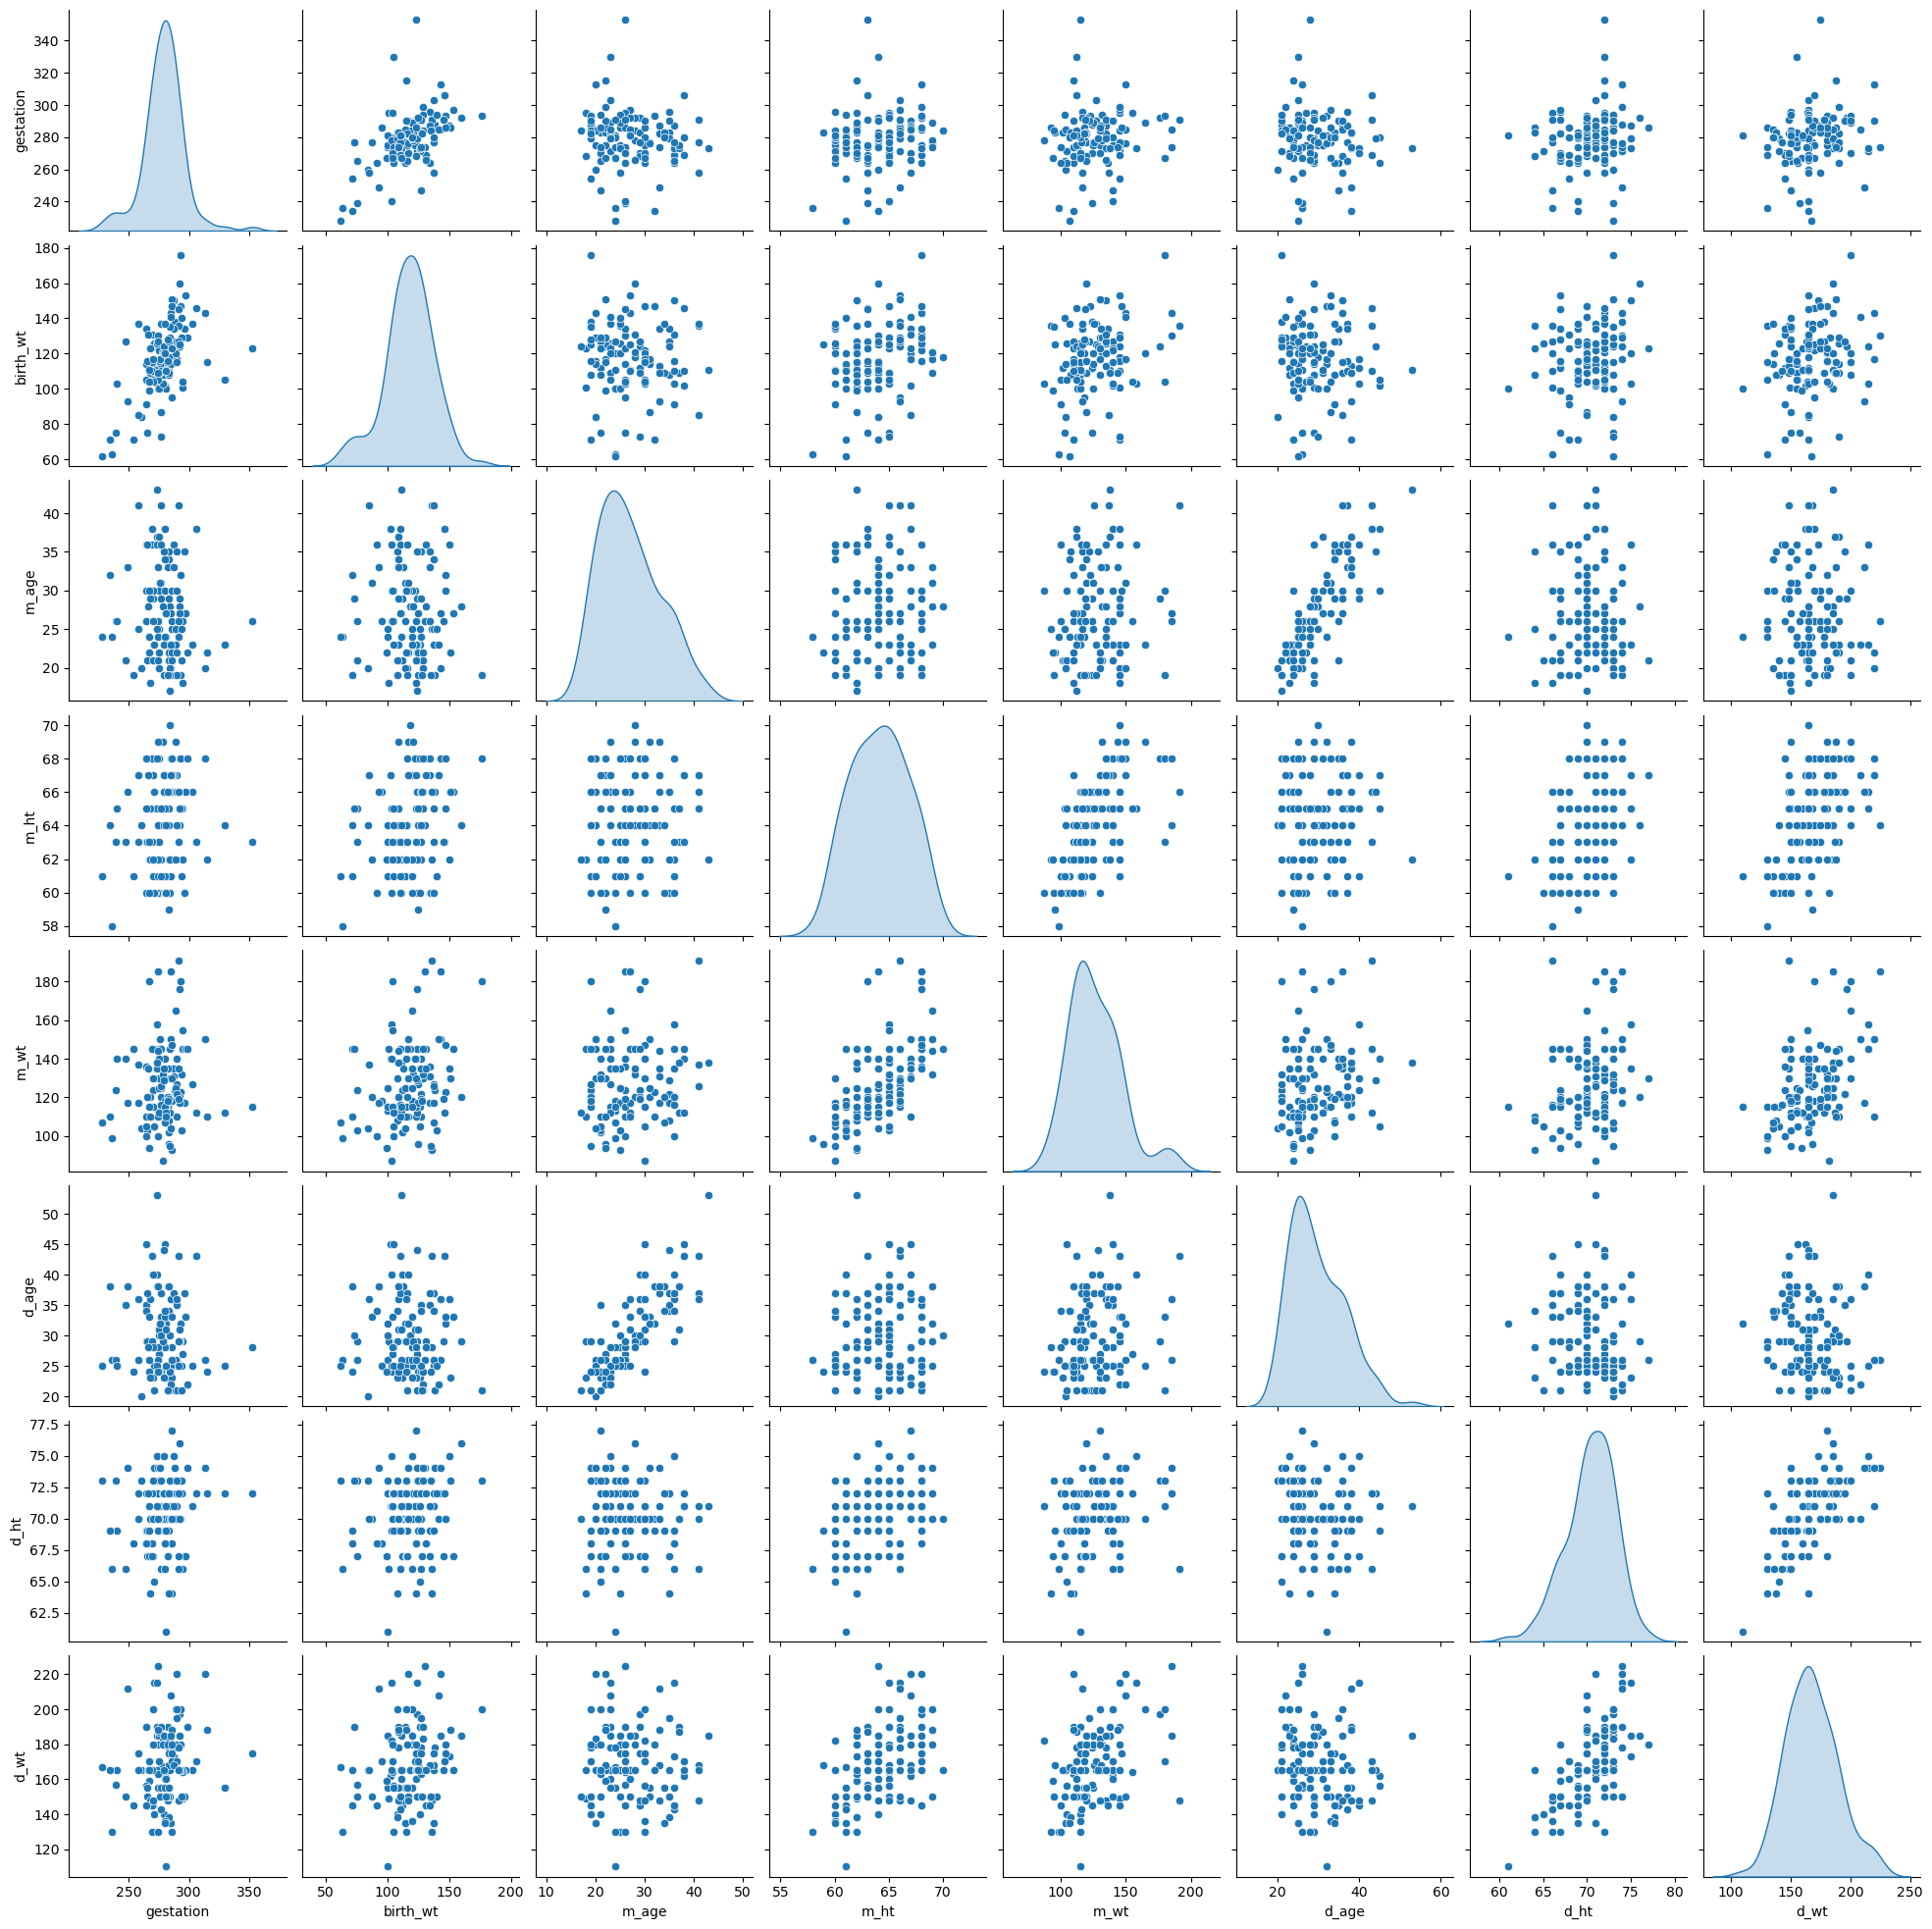

In [20]:
import seaborn as sns
import matplotlib.pyplot as plt

#diag_kind는 대각선 라인의 그래프를 kde로 설정한 것(각 데이터의 정규성을 어느정도 확인할 수 있음)
sns.pairplot(df,diag_kind='kde');

- birth_wt와 gestation는 양의 상관관계가 있음
- m_age 와 d_age 는 양의 상관관계가 있음 → 다중공선성 가능성 있음
- m_wt 와 m_ht는 양의 상관관계가 있음 다중공선성 가능성 있음
- d_wt와 d_ht는 양의 상관관계가 있음 다중공선성 가능성 있음

VIF를 이용한 다중공선성 확인

In [21]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm

#데이터프레임 복사
#다중공선성 검사에 종속변수는 필요 없으므로 제거
df_vif=df.copy().drop(columns=['birth_wt'])

vif=pd.DataFrame()
vif['var_name']=df_vif.columns

#각 열별 VIF 계산
vif['VIF']=[variance_inflation_factor(df_vif.values,i) for i in range(df_vif.shape[1])]

#VIF 값이 큰 순서로 정렬하여 출력
vif.sort_values('VIF',ascending=False)

,var_name,VIF
2,m_ht,714.987095
5,d_ht,694.464294
0,gestation,256.390761
6,d_wt,102.984671
4,d_age,75.378457
1,m_age,70.413361
3,m_wt,63.735582


- 모든 변수의 VIF 가 5 이상이므로 다중공선성이 존재함
- 회귀 분석 결과를 보면서 다중공선성을 제거하기 위한 변수를 선택하기로 결정

회귀계수의 추정

In [23]:
import statsmodels.formula.api as smf

formula='birth_wt~gestation+m_age+m_ht+m_wt+d_age+d_ht+d_wt'
model=smf.ols(formula,data=df).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               birth_wt   R-squared:                       0.344
Model:                            OLS   Adj. R-squared:                  0.302
Method:                 Least Squares   F-statistic:                     8.174
Date:                Mon, 07 Jul 2025   Prob (F-statistic):           5.58e-08
Time:                        03:29:46   Log-Likelihood:                -490.56
No. Observations:                 117   AIC:                             997.1
Df Residuals:                     109   BIC:                             1019.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -99.0165     57.955     -1.709      0.090    -213.881      15.848
gestation      0.5941      0.093      6.358      0.000       0.409       0.779
m_age          0.0740      0.464      0.159      0.874      -0.846       0.994
m_ht           0.7760      0.760      1.021      0.310      -0.731       2.283
m_wt           0.1482      0.098      1.509      0.134      -0.047       0.343
d_age         -0.1748      0.440     -0.398      0.692      -1.046       0.697
d_ht          -0.2654      0.719     -0.369      0.713      -1.690       1.160
d_wt           0.0241      0.099      0.242      0.809      -0.173       0.221
==============================================================================
Omnibus:                        1.360   Durbin-Watson:                   1.875
Prob(Omnibus):                  0.507   Jarque-Bera (JB):                0.915
Skew:                          -0.183   Prob(JB):                        0.633
Kurtosis:                       3.230   Cond. No.                     1.38e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.38e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

결정계수 값이 0.302로 크지 않은 거 같지만 F 검정 결과 유의수준보다 작으므로 모형은 유의함을 나타냄(계수가 0이 아닌 변수가 하나라도 있다)      
AIC와 BIC는 다중공선성으로 인한 독립변수를 제거한 경우 변화한 모형과의 상대비교에만 사용되고 절대적인 크기는 별 다른 의미를 나타내지 않는다.(작아질수록 좋다)   
Cond.No.값이 굉장히 크게 나오므로 다중공선성을 제거해야 함

p-value가 가장 큰 것부터 제거하기도 하지만 문제의 특성 상 태아무게(종속변수)와 큰 연관성이 있는 것은 엄마 쪽의 데이터일 것이므로 아빠의 데이터 상에서 먼저 변수를 제거한다고 했을 때 p-value가 큰 d_wt를 제거하기로 결정

- p-value가 크다는 것은 종속변수에 큰 영향을 주지 못한다는 의미

In [25]:
#d_wt제거
formula='birth_wt~gestation+m_age+m_ht+m_wt+d_age+d_ht'
model=smf.ols(formula,data=df).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               birth_wt   R-squared:                       0.344
Model:                            OLS   Adj. R-squared:                  0.308
Method:                 Least Squares   F-statistic:                     9.608
Date:                Mon, 07 Jul 2025   Prob (F-statistic):           1.74e-08
Time:                        03:38:24   Log-Likelihood:                -490.59
No. Observations:                 117   AIC:                             995.2
Df Residuals:                     110   BIC:                             1015.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   -104.2962     53.473     -1.950      0.054    -210.268       1.675
gestation      0.5953      0.093      6.408      0.000       0.411       0.779
m_age          0.0799      0.462      0.173      0.863      -0.835       0.995
m_ht           0.8080      0.745      1.084      0.281      -0.669       2.285
m_wt           0.1535      0.095      1.610      0.110      -0.035       0.343
d_age         -0.1878      0.435     -0.432      0.667      -1.049       0.674
d_ht          -0.1734      0.608     -0.285      0.776      -1.378       1.031
==============================================================================
Omnibus:                        1.461   Durbin-Watson:                   1.873
Prob(Omnibus):                  0.482   Jarque-Bera (JB):                1.003
Skew:                          -0.193   Prob(JB):                        0.606
Kurtosis:                       3.239   Cond. No.                     1.13e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.13e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

dad의 데이터 중 가장 p-value가 큰 d_ht 제거

In [26]:
#d_ht 제거
formula='birth_wt~gestation+m_age+m_ht+m_wt+d_age'
model=smf.ols(formula,data=df).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               birth_wt   R-squared:                       0.343
Model:                            OLS   Adj. R-squared:                  0.314
Method:                 Least Squares   F-statistic:                     11.61
Date:                Mon, 07 Jul 2025   Prob (F-statistic):           4.94e-09
Time:                        03:39:07   Log-Likelihood:                -490.63
No. Observations:                 117   AIC:                             993.3
Df Residuals:                     111   BIC:                             1010.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   -112.1245     45.700     -2.454      0.016    -202.681     -21.568
gestation      0.5926      0.092      6.439      0.000       0.410       0.775
m_age          0.0634      0.456      0.139      0.890      -0.840       0.967
m_ht           0.7514      0.716      1.050      0.296      -0.666       2.169
m_wt           0.1519      0.095      1.602      0.112      -0.036       0.340
d_age         -0.1656      0.426     -0.389      0.698      -1.009       0.678
==============================================================================
Omnibus:                        1.444   Durbin-Watson:                   1.884
Prob(Omnibus):                  0.486   Jarque-Bera (JB):                1.003
Skew:                          -0.200   Prob(JB):                        0.606
Kurtosis:                       3.215   Cond. No.                     9.49e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 9.49e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

dad의 데이터 중 가장 p-value가 큰 d_age 제거

In [27]:
#d_age 제거
formula='birth_wt~gestation+m_age+m_ht+m_wt'
model=smf.ols(formula,data=df).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               birth_wt   R-squared:                       0.342
Model:                            OLS   Adj. R-squared:                  0.319
Method:                 Least Squares   F-statistic:                     14.58
Date:                Mon, 07 Jul 2025   Prob (F-statistic):           1.28e-09
Time:                        03:39:51   Log-Likelihood:                -490.71
No. Observations:                 117   AIC:                             991.4
Df Residuals:                     112   BIC:                             1005.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   -113.9870     45.275     -2.518      0.013    -203.694     -24.280
gestation      0.5950      0.091      6.504      0.000       0.414       0.776
m_age         -0.0835      0.254     -0.328      0.743      -0.587       0.420
m_ht           0.7633      0.712      1.072      0.286      -0.648       2.174
m_wt           0.1478      0.094      1.574      0.118      -0.038       0.334
==============================================================================
Omnibus:                        1.379   Durbin-Watson:                   1.890
Prob(Omnibus):                  0.502   Jarque-Bera (JB):                0.943
Skew:                          -0.192   Prob(JB):                        0.624
Kurtosis:                       3.215   Cond. No.                     9.40e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 9.4e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

p-value가 큰 m_age제거

In [28]:
#m_age 제거
formula='birth_wt~gestation+m_ht+m_wt'
model=smf.ols(formula,data=df).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               birth_wt   R-squared:                       0.342
Model:                            OLS   Adj. R-squared:                  0.324
Method:                 Least Squares   F-statistic:                     19.56
Date:                Mon, 07 Jul 2025   Prob (F-statistic):           2.76e-10
Time:                        03:40:52   Log-Likelihood:                -490.77
No. Observations:                 117   AIC:                             989.5
Df Residuals:                     113   BIC:                             1001.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   -117.1262     44.079     -2.657      0.009    -204.454     -29.798
gestation      0.5982      0.091      6.606      0.000       0.419       0.778
m_ht           0.7721      0.709      1.089      0.278      -0.632       2.177
m_wt           0.1430      0.092      1.548      0.124      -0.040       0.326
==============================================================================
Omnibus:                        1.269   Durbin-Watson:                   1.892
Prob(Omnibus):                  0.530   Jarque-Bera (JB):                0.843
Skew:                          -0.178   Prob(JB):                        0.656
Kurtosis:                       3.214   Cond. No.                     9.15e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 9.15e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [29]:
#m_ht 제거
formula='birth_wt~gestation+m_wt'
model=smf.ols(formula,data=df).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               birth_wt   R-squared:                       0.335
Model:                            OLS   Adj. R-squared:                  0.323
Method:                 Least Squares   F-statistic:                     28.71
Date:                Mon, 07 Jul 2025   Prob (F-statistic):           8.00e-11
Time:                        03:42:12   Log-Likelihood:                -491.38
No. Observations:                 117   AIC:                             988.8
Df Residuals:                     114   BIC:                             997.0
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -78.3240     25.984     -3.014      0.003    -129.798     -26.850
gestation      0.6098      0.090      6.774      0.000       0.431       0.788
m_wt           0.2024      0.075      2.714      0.008       0.055       0.350
==============================================================================
Omnibus:                        1.837   Durbin-Watson:                   1.878
Prob(Omnibus):                  0.399   Jarque-Bera (JB):                1.350
Skew:                          -0.234   Prob(JB):                        0.509
Kurtosis:                       3.243   Cond. No.                     5.28e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.28e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

잔차플롯으로 회귀 모형의 가정 확인 
- 정규성, 선형성, 독립성, 등분산성

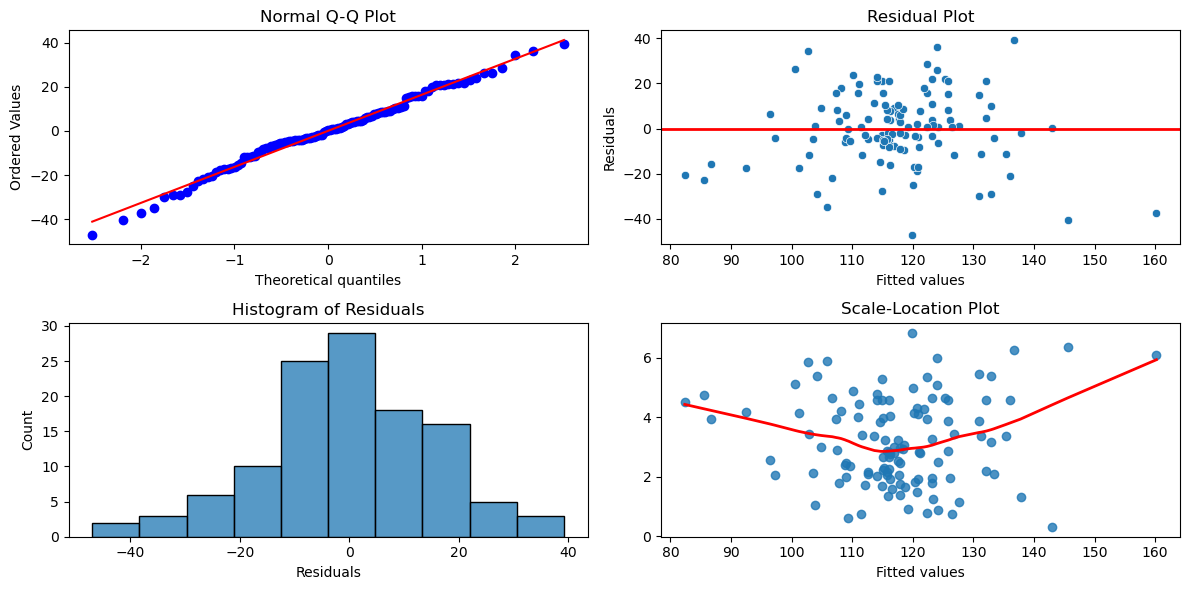

In [30]:
#잔차 플롯 함수 정의
def plotResiduals(model):
    import matplotlib.pyplot as plt
    import seaborn as sns
    import numpy as np
    import scipy.stats as stats

    fig, ax=plt.subplots(2,2,figsize=(12,6))
    resid=np.array(model.resid)
    fitted=np.array(model.fittedvalues)
    #Q-Q plot
    stats.probplot(
        resid,
        dist=stats.norm, #기준 분포는 정규분포
        sparams=(0,1),#정규분포의 평균과 표준편차
        plot=ax[0,0]
    )
    ax[0,0].set_title("Normal Q-Q Plot")

    #Residual Plot
    sns.scatterplot(
        x=fitted,
        y=resid,
        ax=ax[0,1]
    )
    ax[0,1].axhline(0,color='red', linewidth=2)
    ax[0,1].set_xlabel("Fitted values")
    ax[0,1].set_ylabel("Residuals")
    ax[0,1].set_title("Residual Plot")

    #Histogram
    sns.histplot(
        resid,
        bins=10,
        ax=ax[1,0]
    )
    ax[1,0].set_xlabel("Residuals")
    ax[1,0].set_title("Histogram of Residuals")

    #Scale-Location Plot
    sns.regplot(
        x=fitted,
        y=np.sqrt(np.abs(resid)), #잔차에 절댓값을 씌운 후 제곱근을 구함
        scatter=True,
        lowess=True,#데이터들을 따라가면서 그리는 것
        line_kws={'color':'red','lw':2},
        ax=ax[1,1]
    )
    ax[1,1].set_xlabel("Fitted values")
    ax[1,1].set_title("Scale-Location Plot")

    plt.tight_layout()
plotResiduals(model)